In [1]:
import os
import numpy as np
import torch
from torchsummary import summary

import scipy.io.wavfile
import cupy as cp
import cusignal

from IPython.display import Audio

In [2]:
class data_from_dir(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, file_dir, resample=False):
        'Initialization'
        self.resample = resample
        self.file_dir = file_dir
        self.file_filenames = [ x for x in os.listdir(file_dir) ]
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_filenames)

    def __getitem__(self, index, resample=False):
        'Load one sample of data'
        # Select sample
        sr, wave = scipy.io.wavfile.read(os.path.join(self.file_dir, self.file_filenames[index]))
        if self.resample:
            # Let's resample and scale:
            target_length = 5 # seconds
            target_sr = 48000 # sampling rate, samples per second
            wave_gpu = cp.asarray(wave)
            resampled_wave_gpu = cusignal.resample(wave_gpu, target_sr*target_length)
            resampled_wave = cp.asnumpy(resampled_wave_gpu).astype(int)
            scaled_wave = np.int16(resampled_wave/np.max(np.abs(resampled_wave)) * 32767)
            return scaled_wave.reshape(1, -1) # each element in array is one-dimensional, so need to reshape as 1-dimensional array
        else:
            return wave.reshape(1, -1)
            

In [3]:
%%time
# dataset = data_from_dir("../data/dataset/resampled", resample=False) # load already prepared and resampled files
dataset = data_from_dir("../data/dataset/small", resample=False) # load already prepared and resampled files
print("Dataset size: ", len(dataset))

# # check all files to be consistent before pass to neural network
# for index, wave in enumerate(dataset):
#     if len(wave[0]) != 240000:
#         print("Size error:     ", dataset.file_filenames[index])
#         print("Current length: ", len(dataset[index]))
#         break
# if index+1 == len(dataset):
#     print("All files consistent and have same length 240k amplitudes each")
# print()
# print()

# wave

Dataset size:  2000
CPU times: user 2.95 ms, sys: 0 ns, total: 2.95 ms
Wall time: 2.08 ms


In [4]:
%%time
# check one file in dataset to be sure everything is good:
file_number=7
wave = dataset[file_number][0]
sr = 48000

print('Type:              ', type(wave))
print('Data:              ', wave)
print('Sampling rate:     ', sr)
print('Samples:           ', len(wave))
print('Audio length:      ', round(wave.size/sr, 4), 'seconds')
print('Lowest amplitude:  ', min(wave))
print('Highest amplitude: ', max(wave))
print()
print("Scaled from dataset:")
Audio(wave, rate=sr)


Type:               <class 'numpy.ndarray'>
Data:               [ -8647 -10090  -9741 ...  -2161  -2124  -3448]
Sampling rate:      48000
Samples:            240000
Audio length:       5.0 seconds
Lowest amplitude:   -27862
Highest amplitude:  32767

Scaled from dataset:
CPU times: user 109 ms, sys: 7.45 ms, total: 117 ms
Wall time: 117 ms


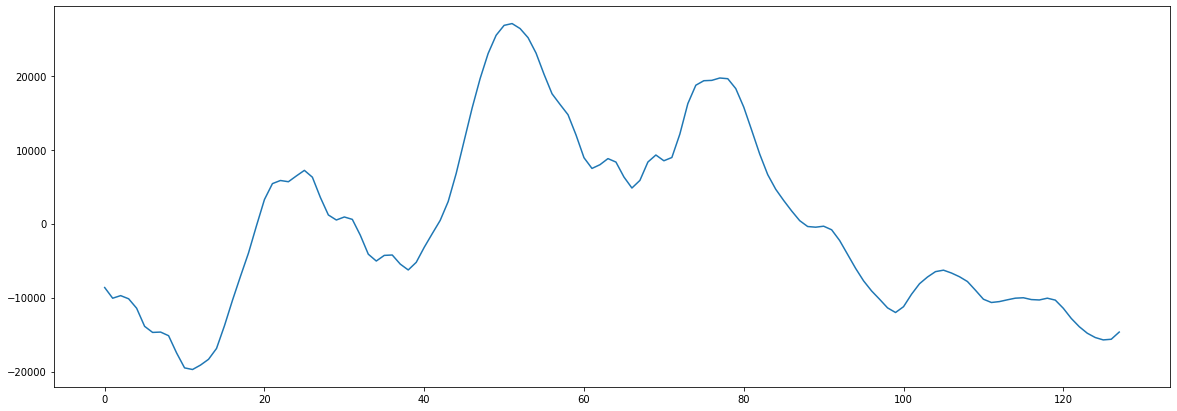

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,7))
plt.plot(dataset[file_number][0][0:128]) # plotting by columns
plt.show()

In [6]:
%%time
print("Original source:")
sr, wave = scipy.io.wavfile.read(os.path.join("../data/sliced", dataset.file_filenames[file_number]))
Audio(wave, rate=sr)

Original source:
CPU times: user 3.39 ms, sys: 467 µs, total: 3.86 ms
Wall time: 2.98 ms


In [7]:
%%time
# now split whole dataset to train and test subsets
# get 50% for tests

train_size = int(0.5 * len(dataset))
# train_size = int(0.9 * len(dataset))
# train_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print("Train dataset size: ", len(train_dataset))
print("Test dataset size:  ", len(test_dataset))
print()

Train dataset size:  1000
Test dataset size:   1000

CPU times: user 1.3 ms, sys: 75 µs, total: 1.37 ms
Wall time: 665 µs


In [8]:
%%time
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True) #, num_workers=4) # num_workers have an issue, not working
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True) #, num_workers=4)

CPU times: user 88 µs, sys: 0 ns, total: 88 µs
Wall time: 91.6 µs


In [9]:
### library for plot online update
from livelossplot import PlotLosses

dataloaders = {
    "train": train_loader,
    "test": test_loader
}

In [10]:
# for idx, inputs in enumerate(train_loader):
#     None
# amplitude_range = 32767*2+1.0 # = 65535
# normalized = 0.5 + inputs/amplitude_range # [0..1]

In [11]:
# # describe model architecture

# # class Recurrent(nn.Module):
# #     def __init__(self, rnn_size):
# #         super(Recurrent, self).__init__()
# #         self.gru = nn.GRU(input_size=3, hidden_size=rnn_size)
# #         self.fc = nn.Linear(rnn_size, 2)

# #     def forward(self, x):
# #         x = x.permute(2, 0, 1)
# #         output, hidden = self.gru(x)
# #         return self.fc(hidden.squeeze(0))

# class ConvAutoencoder(torch.nn.Module):
#     def __init__(self):
#         super(ConvAutoencoder, self).__init__()
#         # 240k - 9600 - 600 - 50 - 5 - 1
#         # encoder
#         # 240k with 1-dimension using window=48 goes to 4-dimension and will maxpool feature map to 9600 outputs
#         self.encoder1 = torch.nn.Sequential(torch.nn.Conv1d(1, 32, kernel_size=48, stride=1, padding=24, dilation=1), 
#                                     torch.nn.ReLU(), 
#                                     torch.nn.MaxPool1d(kernel_size=25, stride=25))
#         # feature map = 600
#         self.encoder2 = torch.nn.Sequential(torch.nn.Conv1d(32, 64, kernel_size=48, stride=1, padding=24, dilation=1), 
#                                     torch.nn.ReLU(), 
#                                     torch.nn.MaxPool1d(kernel_size=16, stride=16))
#         # feature map = 50
#         self.encoder3 = torch.nn.Sequential(torch.nn.Conv1d(64, 128, kernel_size=12, stride=1, padding=6, dilation=1), 
#                                     torch.nn.ReLU(), 
#                                     torch.nn.MaxPool1d(kernel_size=12, stride=12))
#         # feature map = 5
#         self.encoder4 = torch.nn.Sequential(torch.nn.Conv1d(128, 256, kernel_size=4, stride=1, padding=2, dilation=1), 
#                                     torch.nn.ReLU(), 
#                                     torch.nn.MaxPool1d(kernel_size=10, stride=10))
 
#         # decoder 
#         # a kernel of 5 and a stride of 5 will increase the spatial dims by 5 - like "un-maxpooling"
#         self.decoder1 = torch.nn.ConvTranspose1d(256, 128, kernel_size=10, stride=10)
#         self.decoder2 = torch.nn.ConvTranspose1d(128, 64, kernel_size=12, stride=12)
#         self.decoder3 = torch.nn.ConvTranspose1d(64, 32, kernel_size=16, stride=16)
#         self.decoder4 = torch.nn.ConvTranspose1d(32, 1, kernel_size=25, stride=25)
 

#     def forward(self, x):
#         #print("input:", len(x[0][0]))
#         x = self.encoder1(x)
#         #print("encoder 1:", len(x[0]))
#         x = self.encoder2(x)
#         #print("encoder 2:", len(x[0]))
#         x = self.encoder3(x)
#         #print("encoder 3:", len(x[0]))
#         x = self.encoder4(x)
#         #print("encoder 4:", len(x[0]))
        
#         x = torch.nn.functional.relu(self.decoder1(x))
#         #print("decoder 1:", len(x[0]))
#         x = torch.nn.functional.relu(self.decoder2(x))
#         #print("decoder 2:", len(x[0]))
#         x = torch.nn.functional.relu(self.decoder3(x))
#         #print("decoder 3:", len(x[0]))
#         x = torch.nn.functional.tanh(self.decoder4(x))
#         #print("output 4:", len(x[0][0]))
#         x = x.view(-1, 5*10*12*16*25) # 240000
#         # output layer (with sigmoid for scaling from 0 to 1)
#         #x = torch.nn.functional.sigmoid(x)
#         return x

In [12]:
# describe model architecture

class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        kernel_size_1 = int(128) # 128, stride=2, pool=2
        kernel_size_2 = int(49) # 25
        kernel_size_3 = int(37) # 9
        kernel_size_4 = int(25) # 5
        kernel_size_5 = int(17) # 5
        kernel_size_6 = int(9) # 5
        kernel_size_7 = int(5) # 5
        kernel_size_8 = int(5) # 5

        padding_1 = int((kernel_size_1 - 1)/2) # 
        padding_2 = int((kernel_size_2 - 1)/2) # 
        padding_3 = int((kernel_size_3 - 1)/2) # 
        padding_4 = int((kernel_size_4 - 1)/2) # 
        padding_5 = int((kernel_size_5 - 1)/2) # 
        padding_6 = int((kernel_size_6 - 1)/2) # 
        padding_7 = int((kernel_size_7 - 1)/2) # 
        padding_8 = int((kernel_size_8 - 1)/2) # 

        # 240k - 9600 - 600 - 40 - 5 - 1
        # encoder
        # 240k -> 30000
        self.enc1co = torch.nn.Conv1d(1, 32, kernel_size=kernel_size_1, stride=2, padding=padding_1)
        self.enc1bn = torch.nn.BatchNorm1d(32)
        self.enc1ac = torch.nn.ReLU()
        self.enc1mp = torch.nn.MaxPool1d(kernel_size=2, stride=2, return_indices=True)

#         # 30000 -> 3750
#         self.enc2co = torch.nn.Conv1d(16, 32, kernel_size=kernel_size_2, stride=1, padding=padding_2)
#         self.enc2bn = torch.nn.BatchNorm1d(32)
#         self.enc2ac = torch.nn.ReLU()
#         self.enc2mp = torch.nn.MaxPool1d(kernel_size=8, stride=8, return_indices=True)

#         # 3750 -> 750
#         self.enc3co = torch.nn.Conv1d(32, 64, kernel_size=kernel_size_3, stride=1, padding=padding_3)
#         self.enc3bn = torch.nn.BatchNorm1d(64)
#         self.enc3ac = torch.nn.ReLU()
#         self.enc3mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)

#         # 750 -> 150
#         self.enc4co = torch.nn.Conv1d(64, 128, kernel_size=kernel_size_4, stride=1, padding=padding_4)
#         self.enc4bn = torch.nn.BatchNorm1d(128)
#         self.enc4ac = torch.nn.ReLU()
#         self.enc4mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)

#         # 150 -> 30
#         self.enc5co = torch.nn.Conv1d(128, 256, kernel_size=kernel_size_5, stride=1, padding=padding_5)
#         self.enc5bn = torch.nn.BatchNorm1d(256)
#         self.enc5ac = torch.nn.ReLU()
#         self.enc5mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)

#         # 30 -> 6
#         self.enc6co = torch.nn.Conv1d(256, 512, kernel_size=kernel_size_6, stride=1, padding=padding_6)
#         self.enc6bn = torch.nn.BatchNorm1d(512)
#         self.enc6ac = torch.nn.ReLU()
#         self.enc6mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)

#         # 6 -> 2
#         self.enc7co = torch.nn.Conv1d(512, 512, kernel_size=kernel_size_7, stride=1, padding=padding_7)
#         self.enc7bn = torch.nn.BatchNorm1d(512)
#         self.enc7ac = torch.nn.ReLU()
#         self.enc7mp = torch.nn.MaxPool1d(kernel_size=3, stride=3, return_indices=True)

#         # 2 -> 1
#         self.enc8co = torch.nn.Conv1d(512, 512, kernel_size=kernel_size_8, stride=1, padding=padding_8)
#         self.enc8bn = torch.nn.BatchNorm1d(512)
#         self.enc8ac = torch.nn.ReLU()
#         self.enc8mp = torch.nn.MaxPool1d(kernel_size=2, stride=2, return_indices=True)

#         # decoder 
#         self.dec8mup = torch.nn.MaxUnpool1d(kernel_size=2, stride=2)
#         self.dec8uco = torch.nn.ConvTranspose1d(512, 512, kernel_size=kernel_size_8, stride=1, padding=padding_8)
#         self.dec8bn = torch.nn.BatchNorm1d(512)
#         self.dec8ac = torch.nn.ReLU()
        
#         self.dec7mup = torch.nn.MaxUnpool1d(kernel_size=3, stride=3)
#         self.dec7uco = torch.nn.ConvTranspose1d(512, 512, kernel_size=kernel_size_7, stride=1, padding=padding_7)
#         self.dec7bn = torch.nn.BatchNorm1d(512)
#         self.dec7ac = torch.nn.ReLU()
        
#         self.dec6mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
#         self.dec6uco = torch.nn.ConvTranspose1d(512, 256, kernel_size=kernel_size_6, stride=1, padding=padding_6)
#         self.dec6bn = torch.nn.BatchNorm1d(256)
#         self.dec6ac = torch.nn.ReLU()

#         self.dec5mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
#         self.dec5uco = torch.nn.ConvTranspose1d(256, 128, kernel_size=kernel_size_5, stride=1, padding=padding_5)
#         self.dec5bn = torch.nn.BatchNorm1d(128)
#         self.dec5ac = torch.nn.ReLU()
        
#         self.dec4mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
#         self.dec4uco = torch.nn.ConvTranspose1d(128, 64, kernel_size=kernel_size_4, stride=1, padding=padding_4)
#         self.dec4bn = torch.nn.BatchNorm1d(64)
#         self.dec4ac = torch.nn.ReLU()

#         self.dec3mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
#         self.dec3uco = torch.nn.ConvTranspose1d(64, 32, kernel_size=kernel_size_3, stride=1, padding=padding_3)
#         self.dec3bn = torch.nn.BatchNorm1d(32)
#         self.dec3ac = torch.nn.ReLU()

#         self.dec2mup = torch.nn.MaxUnpool1d(kernel_size=8, stride=8)
#         self.dec2uco = torch.nn.ConvTranspose1d(32, 16, kernel_size=kernel_size_2, stride=1, padding=padding_2)
#         self.dec2bn = torch.nn.BatchNorm1d(16)
#         self.dec2ac = torch.nn.ReLU()
        
        self.dec1mup = torch.nn.MaxUnpool1d(kernel_size=2, stride=2)
        self.dec1uco = torch.nn.ConvTranspose1d(32, 1, kernel_size=kernel_size_1, stride=2, padding=padding_1)
        self.dec1bn = torch.nn.BatchNorm1d(1)
        self.dec1ac = torch.nn.Sigmoid() # data range will be transformed to [0..1]
        
        # now initialize weights
        torch.nn.init.kaiming_uniform_(self.enc1co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc2co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc3co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc4co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc5co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc6co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc7co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc8co.weight)
        torch.nn.init.kaiming_uniform_(self.dec1uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec2uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec3uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec4uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec5uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec6uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec7uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec8uco.weight)


    def forward(self, x):
        x = self.enc1co(x)
        x = self.enc1bn(x)
        x = self.enc1ac(x)
        x,self.idx1 = self.enc1mp(x)
#         x = self.enc2co(x)
#         x = self.enc2bn(x)
#         x = self.enc2ac(x)
#         x,self.idx2 = self.enc2mp(x)
#         x = self.enc3co(x)
#         x = self.enc3bn(x)
#         x = self.enc3ac(x)
#         x,self.idx3 = self.enc3mp(x)
#         x = self.enc4co(x)
#         x = self.enc4bn(x)
#         x = self.enc4ac(x)
#         x,self.idx4 = self.enc4mp(x)
#         x = self.enc5co(x)
#         x = self.enc5bn(x)
#         x = self.enc5ac(x)
#         x,self.idx5 = self.enc5mp(x)
#         x = self.enc6co(x)
#         x = self.enc6bn(x)
#         x = self.enc6ac(x)
#         x,self.idx6 = self.enc6mp(x)
#         x = self.enc7co(x)
#         x = self.enc7bn(x)
#         x = self.enc7ac(x)
#         x,self.idx7 = self.enc7mp(x)
#         x = self.enc8co(x)
#         x = self.enc8bn(x)
#         x = self.enc8ac(x)
#         x,self.idx8 = self.enc8mp(x)

#         x = self.dec8mup(x, self.idx8)
#         x = self.dec8uco(x)
#         x = self.dec8bn(x)
#         x = self.dec8ac(x)
#         x = self.dec7mup(x, self.idx7)
#         x = self.dec7uco(x)
#         x = self.dec7bn(x)
#         x = self.dec7ac(x)
#         x = self.dec6mup(x, self.idx6)
#         x = self.dec6uco(x)
#         x = self.dec6bn(x)
#         x = self.dec6ac(x)
#         x = self.dec5mup(x, self.idx5)
#         x = self.dec5uco(x)
#         x = self.dec5bn(x)
#         x = self.dec5ac(x)
#         x = self.dec4mup(x, self.idx4)
#         x = self.dec4uco(x)
#         x = self.dec4bn(x)
#         x = self.dec4ac(x)
#         x = self.dec3mup(x, self.idx3)
#         x = self.dec3uco(x)
#         x = self.dec3bn(x)
#         x = self.dec3ac(x)
#         x = self.dec2mup(x, self.idx2)
#         x = self.dec2uco(x)
#         x = self.dec2bn(x)
#         x = self.dec2ac(x)
        x = self.dec1mup(x, self.idx1)
        x = self.dec1uco(x)
        x = self.dec1bn(x)
        x = self.dec1ac(x)

        return x

In [13]:
# # describe model architecture

# class ConvAutoencoder(torch.nn.Module):
#     def __init__(self):
#         super(ConvAutoencoder, self).__init__()
#         kernel_size_1 = int(65) # 49
#         kernel_size_2 = int(33) # 25
#         kernel_size_3 = int(17) # 9
#         kernel_size_4 = int(9) # 5
#         kernel_size_5 = int(5) # 5

#         padding_1 = int((kernel_size_1 - 1)/2) # 
#         padding_2 = int((kernel_size_2 - 1)/2) # 
#         padding_3 = int((kernel_size_3 - 1)/2) # 
#         padding_4 = int((kernel_size_4 - 1)/2) # 
#         padding_5 = int((kernel_size_5 - 1)/2) # 

#         # encoder
#         # 240k -> 30000
#         self.enc1co = torch.nn.Conv1d(1, 32, kernel_size=kernel_size_1, stride=1, padding=padding_1)
#         self.enc1bn = torch.nn.BatchNorm1d(32)
#         self.enc1ac = torch.nn.ReLU()
#         self.enc1mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)

#         # 30000 -> 3750
#         self.enc2co = torch.nn.Conv1d(32, 64, kernel_size=kernel_size_2, stride=1, padding=padding_2)
#         self.enc2bn = torch.nn.BatchNorm1d(64)
#         self.enc2ac = torch.nn.ReLU()
#         self.enc2mp = torch.nn.MaxPool1d(kernel_size=10, stride=10, return_indices=True)

#         # 3750 -> 750
#         self.enc3co = torch.nn.Conv1d(64, 128, kernel_size=kernel_size_3, stride=1, padding=padding_3)
#         self.enc3bn = torch.nn.BatchNorm1d(128)
#         self.enc3ac = torch.nn.ReLU()
#         self.enc3mp = torch.nn.MaxPool1d(kernel_size=12, stride=12, return_indices=True)

#         # 750 -> 150
#         self.enc4co = torch.nn.Conv1d(128, 256, kernel_size=kernel_size_4, stride=1, padding=padding_4)
#         self.enc4bn = torch.nn.BatchNorm1d(256)
#         self.enc4ac = torch.nn.ReLU()
#         self.enc4mp = torch.nn.MaxPool1d(kernel_size=16, stride=16, return_indices=True)

#         # 150 -> 30
#         self.enc5co = torch.nn.Conv1d(256, 512, kernel_size=kernel_size_5, stride=1, padding=padding_5)
#         self.enc5bn = torch.nn.BatchNorm1d(512)
#         self.enc5ac = torch.nn.ReLU()
#         self.enc5mp = torch.nn.MaxPool1d(kernel_size=25, stride=25, return_indices=True)

#         # decoder 

#         self.dec5mup = torch.nn.MaxUnpool1d(kernel_size=25, stride=25)
#         self.dec5uco = torch.nn.ConvTranspose1d(512, 256, kernel_size=kernel_size_5, stride=1, padding=padding_5)
#         self.dec5bn = torch.nn.BatchNorm1d(256)
#         self.dec5ac = torch.nn.ReLU()
        
#         self.dec4mup = torch.nn.MaxUnpool1d(kernel_size=16, stride=16)
#         self.dec4uco = torch.nn.ConvTranspose1d(256, 128, kernel_size=kernel_size_4, stride=1, padding=padding_4)
#         self.dec4bn = torch.nn.BatchNorm1d(128)
#         self.dec4ac = torch.nn.ReLU()

#         self.dec3mup = torch.nn.MaxUnpool1d(kernel_size=12, stride=12)
#         self.dec3uco = torch.nn.ConvTranspose1d(128, 64, kernel_size=kernel_size_3, stride=1, padding=padding_3)
#         self.dec3bn = torch.nn.BatchNorm1d(64)
#         self.dec3ac = torch.nn.ReLU()

#         self.dec2mup = torch.nn.MaxUnpool1d(kernel_size=10, stride=10)
#         self.dec2uco = torch.nn.ConvTranspose1d(64, 32, kernel_size=kernel_size_2, stride=1, padding=padding_2)
#         self.dec2bn = torch.nn.BatchNorm1d(32)
#         self.dec2ac = torch.nn.ReLU()
        
#         self.dec1mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
#         self.dec1uco = torch.nn.ConvTranspose1d(32, 1, kernel_size=kernel_size_1, stride=1, padding=padding_1)
#         self.dec1bn = torch.nn.BatchNorm1d(1)
#         self.dec1ac = torch.nn.Sigmoid() # data range will be transformed to [0..1]
        
#         # now initialize weights
#         torch.nn.init.kaiming_uniform_(self.enc1co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc2co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc3co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc4co.weight)
#         torch.nn.init.kaiming_uniform_(self.enc5co.weight)
#         torch.nn.init.kaiming_uniform_(self.dec1uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec2uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec3uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec4uco.weight)
#         torch.nn.init.kaiming_uniform_(self.dec5uco.weight)


#     def forward(self, x):
#         x = self.enc1co(x)
#         x = self.enc1bn(x)
#         x = self.enc1ac(x)
#         x,self.idx1 = self.enc1mp(x)
#         x = self.enc2co(x)
#         x = self.enc2bn(x)
#         x = self.enc2ac(x)
#         x,self.idx2 = self.enc2mp(x)
#         x = self.enc3co(x)
#         x = self.enc3bn(x)
#         x = self.enc3ac(x)
#         x,self.idx3 = self.enc3mp(x)
#         x = self.enc4co(x)
#         x = self.enc4bn(x)
#         x = self.enc4ac(x)
#         x,self.idx4 = self.enc4mp(x)
#         x = self.enc5co(x)
#         x = self.enc5bn(x)
#         x = self.enc5ac(x)
#         x,self.idx5 = self.enc5mp(x)

#         x = self.dec5mup(x, self.idx5)
#         x = self.dec5uco(x)
#         x = self.dec5bn(x)
#         x = self.dec5ac(x)
#         x = self.dec4mup(x, self.idx4)
#         x = self.dec4uco(x)
#         x = self.dec4bn(x)
#         x = self.dec4ac(x)
#         x = self.dec3mup(x, self.idx3)
#         x = self.dec3uco(x)
#         x = self.dec3bn(x)
#         x = self.dec3ac(x)
#         x = self.dec2mup(x, self.idx2)
#         x = self.dec2uco(x)
#         x = self.dec2bn(x)
#         x = self.dec2ac(x)
#         x = self.dec1mup(x, self.idx1)
#         x = self.dec1uco(x)
#         x = self.dec1bn(x)
#         x = self.dec1ac(x)

#         return x

In [14]:
model = ConvAutoencoder()
model.cuda() # need to be set to cuda to get summary working
summary(model, (1, 240000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [-1, 32, 120000]           4,128
       BatchNorm1d-2           [-1, 32, 120000]              64
              ReLU-3           [-1, 32, 120000]               0
         MaxPool1d-4  [[-1, 32, 60000], [-1, 32, 60000]]               0
       MaxUnpool1d-5           [-1, 32, 120000]               0
   ConvTranspose1d-6            [-1, 1, 240000]           4,097
       BatchNorm1d-7            [-1, 1, 240000]               2
           Sigmoid-8            [-1, 1, 240000]               0
Total params: 8,291
Trainable params: 8,291
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.92
Forward/backward pass size (MB): 28124877.32
Params size (MB): 0.03
Estimated Total Size (MB): 28124878.27
----------------------------------------------------------------


In [15]:
# train on cuda if available
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# train with (test on each epoch)
def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    amplitude_range = 32767*2 + 1.0 # = 65535
#     softmaxed = torch.nn.Softmax()
    
    for epoch_id, epoch in enumerate(range(num_epochs)):
        logs = {}
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            # running_corrects = 0 # no correct answers for autoencoders

            for idx, inputs in enumerate(dataloaders[phase]):
                inputs = 0.5 + (inputs/amplitude_range) # [0..1]
                inputs = inputs.to(device)
                outputs = model(inputs)
                loss = (criterion(outputs, inputs))

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # _, preds = torch.max(outputs, 1) # no correct answers for autoencoders
                running_loss += loss.detach() * inputs.size(0)
                # running_corrects += torch.sum(preds == inputs.data) # no correct answers for autoencoders
                # running_corrects += torch.sum(preds == labels.data) # no correct answers for autoencoders
                ###print(f"\r[{idx}/{len(source_files)}] {round(100.0 * idx/len(source_files), 2)}%: {j}", end = "")


            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'test':
                prefix = 'val_'
            logs[prefix + 'log loss'] = epoch_loss.item() 
        liveloss.update(logs)
        liveloss.send()
        print(f"\n[{epoch_id+1}/{num_epochs}]    {logs}")
    print("\nTrained.")

In [16]:
torch.cuda.empty_cache()
model = ConvAutoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # [0.001 .. 0.0005 ... 0.0001]

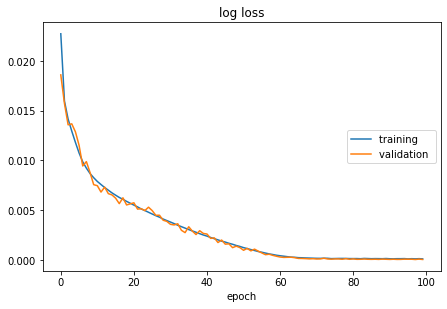

log loss
	training         	 (min:    0.000, max:    0.023, cur:    0.000)
	validation       	 (min:    0.000, max:    0.019, cur:    0.000)

[100/100]    {'log loss': 0.0001041842479025945, 'val_log loss': 4.497517511481419e-05}

Trained.
CPU times: user 32min 46s, sys: 2min 19s, total: 35min 6s
Wall time: 8min 51s


In [17]:
%%time
train_model(model, criterion, optimizer, num_epochs=100)

In [18]:
validation_dataset = data_from_dir("../data/dataset/test", resample=False) # load already prepared and resampled files
print("Dataset size: ", len(validation_dataset))

Dataset size:  524


In [33]:
%%time
# check one file in dataset to be sure everything is good:
file_number=0
wave = validation_dataset[file_number][0]
sr = 48000

print('Type:              ', type(wave))
print('Data:              ', wave)
print('Sampling rate:     ', sr)
print('Samples:           ', len(wave))
print('Audio length:      ', round(wave.size/sr, 4), 'seconds')
print('Lowest amplitude:  ', min(wave))
print('Highest amplitude: ', max(wave))
print()
print("Scaled from dataset:")
Audio(wave, rate=sr)


Type:               <class 'numpy.ndarray'>
Data:               [-1748 -1502 -2013 ... -5373 -4104 -2723]
Sampling rate:      48000
Samples:            240000
Audio length:       5.0 seconds
Lowest amplitude:   -31948
Highest amplitude:  32767

Scaled from dataset:
CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 113 ms


In [34]:
wave = validation_dataset[file_number][0]
amplitude_range = 32767*2+1.0 # = 65535
inputs = torch.Tensor([[0.5 + wave/amplitude_range]]) # [0..1]
inputs = inputs.to(device)
outputs = model(inputs)
loss = (criterion(outputs, inputs))
print(f"loss: {loss.item()}")
result = np.int16(((outputs - 0.5)*(amplitude_range-1)).detach().cpu())
Audio(result[0][0], rate=sr)

loss: 0.00016642945411149412


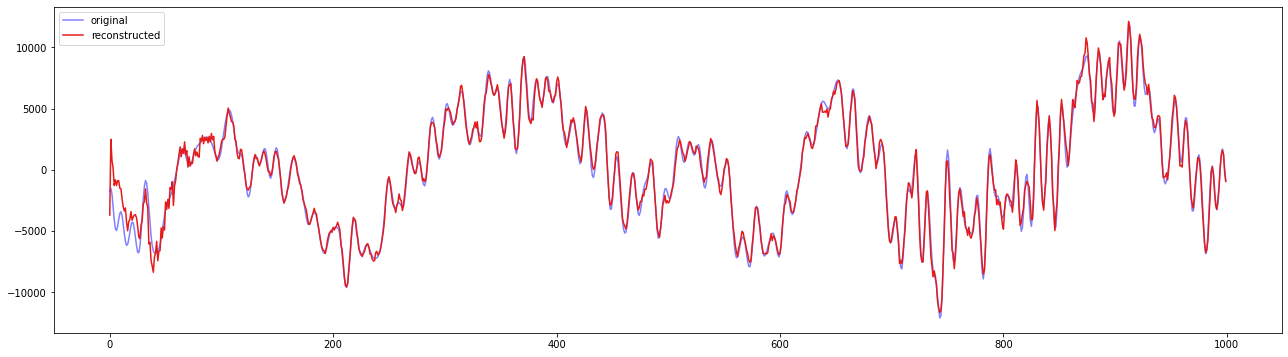

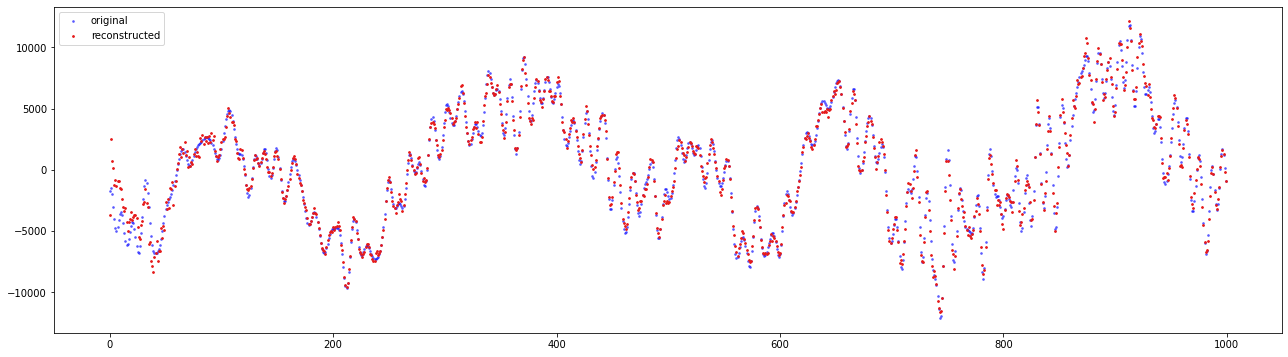

In [35]:
sz=1000
plt.figure(figsize=(22,6))
plt.plot(wave[0:sz], linestyle="-", color=[0.01, 0.01, 1.0, 0.5], label="original") # plotting by columns
plt.plot(result[0][0][0:sz], linestyle="-", color=[0.9, 0.1, 0.1, 1.], label="reconstructed") # plotting by columns
plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(22,6))
x = np.arange(0, sz)
plt.scatter(x, wave[0:sz], s=3, color=[0.01, 0.01, 1.0, 0.5], label="original") # plotting by columns
plt.scatter(x, result[0][0][0:sz], s=3, color=[0.9, 0.1, 0.1, 1.], label="reconstructed") # plotting by columns
plt.legend(loc="upper left")
plt.show()